# Analysis

## input data

In [1]:
from auth import sp
import pandas as pd
from utils import fetch_all_playlist_tracks

# Get user's playlists
playlists = sp.current_user_playlists()
total_playlists = len(playlists['items'])

# Get the tracks from the playlists in the "Rated" folder
tracks = []
for i, playlist in enumerate(playlists['items']):
    if playlist['name'] in ["0.0", "0.5", "1.0", "1.5", "2.0", "2.5", "3.0", "3.5", "4.0", "4.5", "5.0"]:
        playlist_id = playlist['id']
        playlist_tracks = fetch_all_playlist_tracks(playlist_id)
        track_ids = [item['track']['id'] for item in playlist_tracks]
        
        # Get audio features for each track
        num_tracks_to_fetch = 100  # Maximum number of tracks to fetch at once
        for j in range(0, len(track_ids), num_tracks_to_fetch):
            audio_features_list = sp.audio_features(track_ids[j:j+num_tracks_to_fetch])
            
            for track, audio_features in zip(playlist_tracks[j:j+num_tracks_to_fetch], audio_features_list):
                track = track['track']
                
                # Merge track and its audio features
                track.update(audio_features)
                
                # Add rating to track
                track['rating'] = float(playlist['name'])  # Convert the playlist name to float and use it as the rating
                tracks.append(track)
    
    print(f'\rProcessed {i+1} of {total_playlists} playlists...', end='')


df = pd.DataFrame(tracks)

# Select columns to keep
columns_to_keep = [
    "album",
    "artists",
    "duration_ms",
    "explicit",
    "href",
    "id",
    "name",
    "popularity",
    "preview_url",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "track_href",
    "time_signature",
    "rating",
]
df = df[columns_to_keep]

# save tracks to csv
print('\nSaving tracks to CSV...')

# try then wait for user input if can't in order for the user to close the file if it's open
try:
    df.to_csv('rated.csv')
except PermissionError:
    input('Please close the file "rated.csv" then press enter to continue...')
    df.to_csv('rated.csv')

print(f'Done. Total number of rated songs: {len(tracks)}')

Processed 15 of 50 playlists...Fetching tracks from '1.0' by Bill
Processed 16 of 50 playlists...Fetching tracks from '1.5' by Bill
Processed 17 of 50 playlists...Fetching tracks from '5.0' by Bill
Processed 18 of 50 playlists...Fetching tracks from '2.5' by Bill
Processed 19 of 50 playlists...Fetching tracks from '2.0' by Bill
Processed 20 of 50 playlists...Fetching tracks from '0.5' by Bill
Processed 21 of 50 playlists...Fetching tracks from '3.0' by Bill
Processed 22 of 50 playlists...Fetching tracks from '4.5' by Bill
Processed 23 of 50 playlists...Fetching tracks from '4.0' by Bill
Processed 24 of 50 playlists...Fetching tracks from '3.5' by Bill
Processed 50 of 50 playlists...
Saving tracks to CSV...
Done. Total number of rated songs: 524


## output data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Load the dataset
data = pd.read_csv("rated.csv")

# Select features and target
X = data[['duration_ms', 'explicit', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
          'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]
y = data['rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.1, max_depth=5)  # Set default hyperparameters

# Train the model
model.fit(X_train, y_train)

# Custom error function to print the error every 100 boosting stages
def print_error(y_true, y_pred, step):
    if step % 100 == 0:
        mse = mean_squared_error(y_true, y_pred)
        print(f"Stage {step} - Mean Squared Error: {mse}")

# Iterate through boosting stages and print error every 100 steps
for stage, y_pred in enumerate(model.staged_predict(X_test), start=1):
    print_error(y_test, y_pred, stage)

# Evaluate the final model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Final Mean Squared Error:", mse)


Stage 100 - Mean Squared Error: 0.6016697449526983
Stage 200 - Mean Squared Error: 0.6106563935220617
Stage 300 - Mean Squared Error: 0.610638899639291
Stage 400 - Mean Squared Error: 0.611154923219441
Stage 500 - Mean Squared Error: 0.6108880056156393
Stage 600 - Mean Squared Error: 0.6109830170666708
Stage 700 - Mean Squared Error: 0.6109875843220064
Stage 800 - Mean Squared Error: 0.610991116538877
Stage 900 - Mean Squared Error: 0.6109895288516995
Stage 1000 - Mean Squared Error: 0.610988981569337
Stage 1100 - Mean Squared Error: 0.6109886072907487
Stage 1200 - Mean Squared Error: 0.6109885025854142
Stage 1300 - Mean Squared Error: 0.6109885101435091
Stage 1400 - Mean Squared Error: 0.6109885068353196
Stage 1500 - Mean Squared Error: 0.6109885036584842
Stage 1600 - Mean Squared Error: 0.6109885038796963
Stage 1700 - Mean Squared Error: 0.6109885036190114
Stage 1800 - Mean Squared Error: 0.6109885036190114
Stage 1900 - Mean Squared Error: 0.6109885036190114
Stage 2000 - Mean Squared

## visualisations

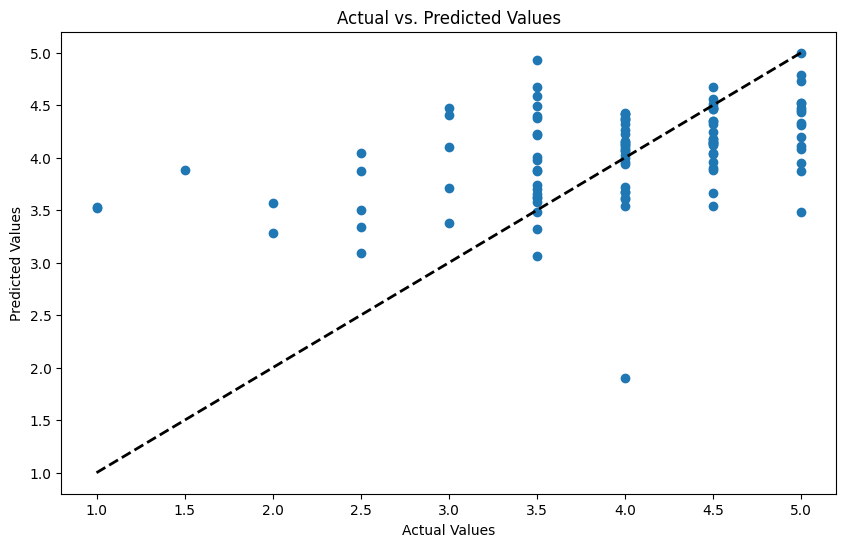

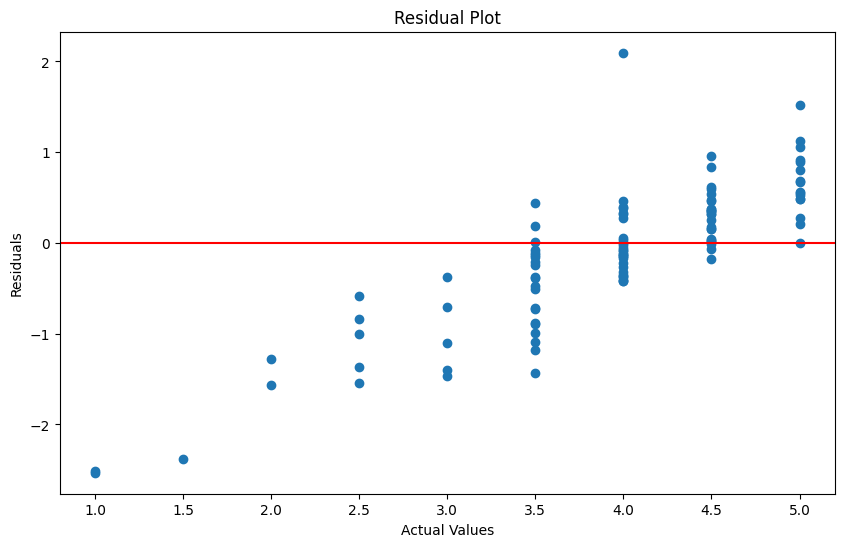

In [3]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Add y=x line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()

# Residual plot
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Give Recommendations to Users Based on Their Preferences

## load unrated songs

In [4]:
sources_ids = [
    "37i9dQZEVXcToZ9oox3nki",
    "37i9dQZF1DWZdLqpoFOt65",
    "37i9dQZEVXbn0l6flXloCt",
    "37i9dQZF1DWW1yuCSjnKtM",
    "22mm5J4DcucnRDLv0BAvti",
    "1h419AHuvIuFXjUjndFC25",
    "0gqrnk12Q8OExuCeKyBRCq",
    "3wXgQJZudZsz7RGyPMTQGa"
]
# discover weekly
# for you.
# release radar
# !!!
# discover weekly (cash)
# discovered weekly (trending.)
# BEST SONGS OF ALL TIME
# best tracks from the top albums of all time - RYM (RateYourMusic)

In [5]:
import os

# Load rated songs if exists
rated_songs = pd.read_csv('rated.csv') if os.path.exists('rated.csv') and os.path.getsize('rated.csv') > 0 else pd.DataFrame()

# Load unrated songs if exists
unrated_songs = pd.read_csv('unrated.csv') if os.path.exists('unrated.csv') and os.path.getsize('unrated.csv') > 0 else pd.DataFrame()

tracks = []

for playlist_id in sources_ids:
    playlist_tracks = fetch_all_playlist_tracks(playlist_id)
    track_ids = [t['track']['id'] for t in playlist_tracks if t['track'] is not None and 'id' in t['track'] and t['track']['id'] not in rated_songs['id'].values and t['track']['id'] is not None]

    # Get audio features for each track
    for j in range(0, len(track_ids), 100):
        try:
            audio_features_list = sp.audio_features(track_ids[j:j+100])
        except Exception as e:
            print(f"Error: {e}")
            continue
        
        for track, audio_features in zip(playlist_tracks[j:j+100], audio_features_list):
            track = track['track']
            
            # Skip if the track is None or if 'id' key doesn't exist in track
            if track is None or 'id' not in track:
                continue
            
            # Skip if song is either already rated
            if 'id' in rated_songs.columns and track['id'] in rated_songs['id'].values:
                continue
            
            # Append track details and audio features to the list
            tracks.append({
                'id': track['id'],
                'name': track['name'],
                'artist': track['artists'][0]['name'],
                'album': track['album']['name'],
                'release_date': track['album']['release_date'],
                'duration_ms': track['duration_ms'],
                'popularity': track['popularity'],
                **audio_features
            })
            
print(f"\n Processed {len(tracks)} tracks")

# Convert to DataFrame and save to CSV
tracks_df = pd.DataFrame(tracks)
tracks_df.to_csv("unrated.csv", index=False)

Fetching tracks from 'Discover Weekly' by Spotify
Fetching tracks from 'for you.' by Spotify
Fetching tracks from 'Release Radar' by Spotify
Fetching tracks from '!!!' by Spotify
Fetching tracks from 'Discover Weekly' by cash
Fetching tracks from 'Discovered Weekly' by trending.
Fetching tracks from 'BEST SONGS OF ALL TIME' by Best Songs Of All Time
Fetching tracks from 'best tracks from the top albums of all time - RYM (RateYourMusic)' by Henrique Oliveira


KeyboardInterrupt: 

## recommend songs

In [ ]:
# Set display options
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', 199)  # or 199

# Load data of unrated songs
unrated_songs = pd.read_csv('unrated.csv')

# Keep a copy of song names, artist, album, and id
song_data = unrated_songs[["name", "artist", "album", "id"]]

# Preprocess data
unrated_songs = unrated_songs.dropna()  # Drop rows with missing values
unrated_songs = pd.get_dummies(unrated_songs.drop(["name", "artist", "album", "id"], axis=1))  # One-hot encode categorical data excluding song data

# Make sure the unrated songs data has the same columns as the training data
missing_cols = set(X_train.columns) - set(unrated_songs.columns)
missing_df = pd.DataFrame(0, index=unrated_songs.index, columns=list(missing_cols))
unrated_songs = pd.concat([unrated_songs, missing_df], axis=1)
unrated_songs = unrated_songs[X_train.columns]

# Predict ratings of unrated songs
predicted_ratings = best_rf.predict(unrated_songs)

# Add predicted ratings and song data to unrated songs data
unrated_songs['predicted_rating'] = predicted_ratings
unrated_songs = pd.concat([unrated_songs, song_data], axis=1)

# Create Spotify link using the song's ID
unrated_songs['spotify_link'] = 'https://open.spotify.com/track/' + unrated_songs['id']

# Recommend the top 10 songs with the highest predicted ratings
recommended_songs = unrated_songs.nlargest(10, 'predicted_rating')

# Reset index and print recommended songs
recommended_songs = recommended_songs.reset_index(drop=True)

# Display the table
recommended_songs[["name", "artist", "album", "spotify_link", "predicted_rating"]]

,name,artist,album,spotify_link,predicted_rating
0,Everybody Hurts,R.E.M.,Automatic For The People,https://open.spotify.com/track/6PypGyiu0Y2lCDBN1XZEnP,2.976667
1,"My Heart Will Go On - Love Theme from ""Titanic""",Céline Dion,Let's Talk About Love,https://open.spotify.com/track/3oEHQmhvFLiE7ZYES0ulzv,2.976667
2,Donna - Single Version,Ritchie Valens,Ritchie Valens,https://open.spotify.com/track/0VE4ayVlGs5DBoqOdgJ0Zv,2.976667
3,Uh Huh,T Danger,"Sorry, I Can't Talk Right Now 2",https://open.spotify.com/track/41YSsQ2sIX5xMEclRyolB5,2.976667
4,Everybody Hurts,R.E.M.,Automatic For The People,https://open.spotify.com/track/6PypGyiu0Y2lCDBN1XZEnP,2.976667
5,Rock 'n' Roll Suicide - 2012 Remaster,David Bowie,The Rise and Fall of Ziggy Stardust and the Spiders from Mars (2012 Remaster),https://open.spotify.com/track/1k5iH4KDKi56MFvlnrALNV,2.976667
6,Rose Parade,Elliott Smith,Either/Or,https://open.spotify.com/track/6EdqqSD6saL8vzmd4xRI8n,2.976667
7,Music for 18 Musicians: Section I,Steve Reich,Music for 18 Musicians,https://open.spotify.com/track/1LWabh9wqLITaRpYe82PoD,2.976667
8,Ladies and Gentlemen We Are Floating in Space,Spiritualized,Ladies & Gentlemen We Are Floating In Space,https://open.spotify.com/track/4aUCovTNe98WnwE6AIl0pU,2.976667
9,Je te veux,Erik Satie,Satie: 3 Gymnopédies; 6 Gnossiennes etc.,https://open.spotify.com/track/5ru4nchmouOKZ7Xno55pzO,2.976667


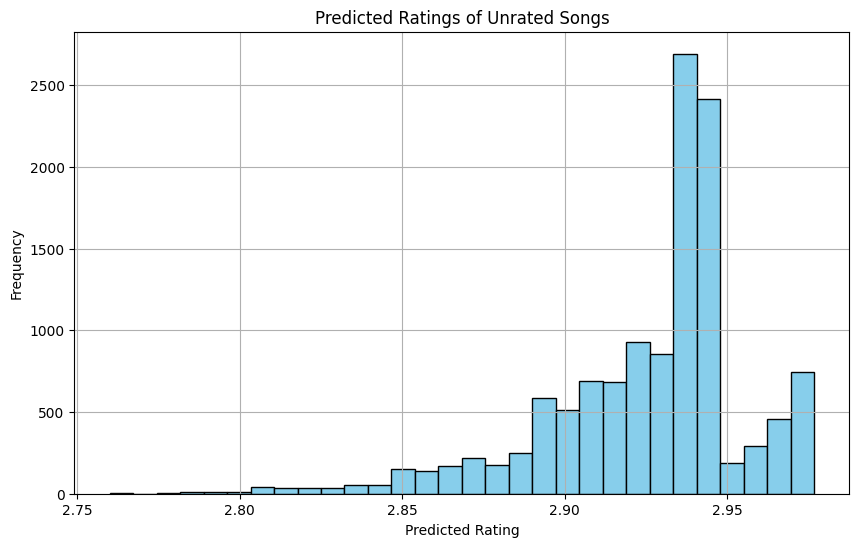

In [ ]:
# Load data of unrated songs
unrated_songs = pd.read_csv('unrated.csv')

# Keep a copy of song names, artist, album, and id
song_data = unrated_songs[["name", "artist", "album", "id"]]

# Preprocess data
unrated_songs = unrated_songs.dropna()  # Drop rows with missing values
unrated_songs = pd.get_dummies(unrated_songs.drop(["name", "artist", "album", "id"], axis=1))  # One-hot encode categorical data excluding song data

# Make sure the unrated songs data has the same columns as the training data
missing_cols = set(X_train.columns) - set(unrated_songs.columns)
missing_df = pd.DataFrame(0, index=unrated_songs.index, columns=list(missing_cols))
unrated_songs = pd.concat([unrated_songs, missing_df], axis=1)
unrated_songs = unrated_songs[X_train.columns]

# Predict ratings of unrated songs
predicted_ratings = best_rf.predict(unrated_songs)

# Add predicted ratings and song data to unrated songs data
unrated_songs['predicted_rating'] = predicted_ratings
unrated_songs = pd.concat([unrated_songs, song_data], axis=1)

# Plot a graph of the predicted ratings
plt.figure(figsize=(10, 6))
plt.hist(unrated_songs['predicted_rating'], bins=30, color='skyblue', edgecolor='black')
plt.title('Predicted Ratings of Unrated Songs')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()